In [1]:
import os
import shutil
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import SGD, Adam

# Clone github repo
!git clone https://github.com/wwentink/pneumonia-detection.git

Cloning into 'pneumonia-detection'...
remote: Enumerating objects: 5859, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 5859 (delta 2), reused 0 (delta 0), pack-reused 5853 (from 3)
Receiving objects: 100% (5859/5859), 1.13 GiB | 16.93 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (5869/5869), done.


In [2]:
dirpath = os.getcwd()

In [3]:
# Define paths to training, validation, and testing data
train_data_dir = '/content/pneumonia-detection/data/chest_xray/train'
test_data_dir = '/content/pneumonia-detection/data/chest_xray/test'
val_data_dir = '/content/pneumonia-detection/data/chest_xray/val'

# Define a base image size
img_height = 224
img_width = 224
batch_size = 32

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  labels='inferred',
  label_mode='binary',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory( # Changed test_ds to val_ds
  val_data_dir, # Changed test_data_dir to val_data_dir
  labels='inferred',
  label_mode='binary',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size)

# Create test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  labels='inferred',
  label_mode='binary',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size)

# Define class names
class_names = train_ds.class_names

# Augment training data
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
  layers.RandomTranslation(0.1, 0.1)
])

# Define model layers
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile and print model outline
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,369 (24.59 MB)

 Trainable params: 6,446,369 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Define callback functions for model performace
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='max')
model_folder = os.path.join(dirpath, 'pneumonia-detection', 'models')
checkpoint_file_cnn = os.path.join(model_folder,'checkpoint.model.keras')
mcp_save = ModelCheckpoint(checkpoint_file_cnn, save_best_only=True, monitor='val_accuracy', mode='max')

# Start model training
history = model.fit(
  train_ds,
  epochs=25,
  verbose=1,
  steps_per_epoch=None,
  validation_data=val_ds,
  callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 205ms/step - accuracy: 0.7611 - loss: 0.5865 - val_accuracy: 0.7500 - val_loss: 0.5755 - learning_rate: 0.0010
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.8589 - loss: 0.3025 - val_accuracy: 0.6250 - val_loss: 0.8538 - learning_rate: 0.0010
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 203ms/step - accuracy: 0.8729 - loss: 0.2849 - val_accuracy: 0.8125 - val_loss: 0.4854 - learning_rate: 0.0010
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.8808 - loss: 0.2747 - val_accuracy: 0.7500 - val_loss: 0.8238 - learning_rate: 0.0010
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 199ms/step - accuracy: 0.9152 - loss: 0.2170 - val_accuracy: 0.7500 - val_loss: 0.8167 - learning_rate: 0.0010
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 200ms/step - accuracy: 0.9226 - loss: 0.2026 - val_accuracy: 0.6250 - val_loss: 1.3461 - learning_rate: 0.0010
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.9

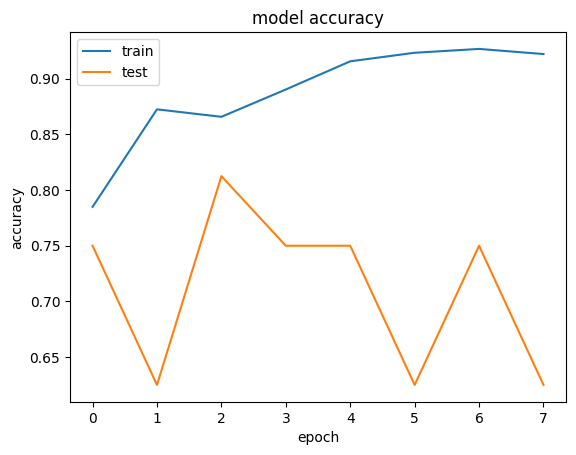

In [5]:
# Plot model accuracy for train and test across epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.8725 - loss: 0.3172
Test Loss: 0.3094800114631653
Test Accuracy: 0.8814102411270142
